# Brain Tumor Detection Using a Convolutional Neural Network

### Import Statements:

- `import tensorflow as tf`: Import the TensorFlow library and alias it as `tf`.

- `from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense`: Import specific layers from the Keras module within TensorFlow. These layers are commonly used in building neural networks.

- `from tensorflow.keras.models import Model, load_model`: Import the `Model` class and `load_model` function from Keras. The `Model` class is used to define neural network models.

- `from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint`: Import callback functions from Keras. Callbacks are used during training to perform actions like saving the model or logging data.

- `from sklearn.model_selection import train_test_split`: Import the `train_test_split` function from scikit-learn. It's commonly used to split a dataset into training and testing sets.

- `from sklearn.metrics import f1_score`: Import the `f1_score` metric from scikit-learn. F1 score is often used in classification tasks.

- `from sklearn.utils import shuffle`: Import the `shuffle` function from scikit-learn. It's used to shuffle arrays or lists.

- `import cv2`: Import the OpenCV library, often used for image processing.

- `import imutils`: Import the `imutils` library, which provides convenience functions for working with images.

- `import numpy as np`: Import the NumPy library and alias it as `np`. NumPy is commonly used for numerical operations in Python.

- `import matplotlib.pyplot as plt`: Import the `matplotlib.pyplot` module for creating visualizations.

- `import time`: Import the `time` module, which can be used for measuring the execution time of code.

- `from os import listdir`: Import the `listdir` function from the `os` module, used to list files in a directory.

- `from keras.preprocessing import image`: Import the `image` module from Keras for image preprocessing.

- `from keras.models import load_model`: Import the `load_model` function from Keras. It's used to load pre-trained models.

- `from keras.applications.resnet50 import preprocess_input`: Import the `preprocess_input` function for pre-processing images before feeding them into a ResNet50 model.

- `from sklearn.decomposition import PCA`: Import the Principal Component Analysis (PCA) class from scikit-learn. PCA is a dimensionality reduction technique.

- `%matplotlib inline`: A Jupyter Notebook magic command to display Matplotlib plots inline.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils # preprocessing img
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
from keras.applications.resnet50 import preprocess_input
from sklearn.decomposition import PCA
%matplotlib inline

### Data Preparation & Preprocessing:

#### Convert to Grayscale and Blur:

- Convert the input color image to grayscale.
- Apply a Gaussian blur to the grayscale image to reduce noise.

#### Thresholding and Morphological Operations:

- Threshold the image to create a binary image.
- Perform a series of erosions and dilations to remove small regions of noise.

#### Find Contours and Identify the Largest One:

- Find contours in the thresholded image.
- Identify the largest contour based on its area.

#### Extreme Points of the Contour:

- Find the extreme points (left, right, top, and bottom) of the largest contour.

#### Crop the Image:

- Crop a new image from the original image using the extreme points.

#### Optional Plotting:

- If the `plot` parameter is set to `True`, the function plots the original and cropped images side by side using matplotlib.

#### Return the Cropped Image:

- The function returns the cropped image.

This function is particularly useful in medical imaging applications where isolating and extracting a specific region of interest (e.g., the brain contour) is necessary. The optional plotting helps visualize the effectiveness of the contour detection and cropping process.


In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

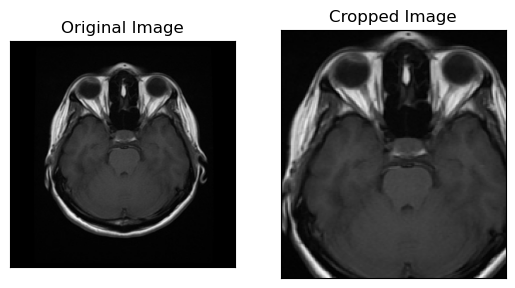

In [6]:
ex_img = cv2.imread("C:\\Users\\lenovo\\OneDrive\\Desktop\\Siar-dataset\\Normal\\Normal (15).jpg")
ex_new_img = crop_brain_contour(ex_img, True)

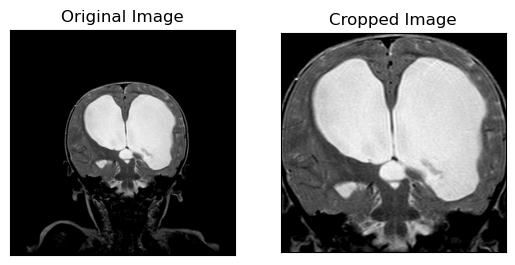

In [5]:
ex_img = cv2.imread("C:\\Users\\lenovo\\OneDrive\\Desktop\\Siar-dataset\\Tumor\\Tumor (200).jpg")
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (64, 64, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [8]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [9]:
augmented_path = 'C:/Users/lenovo/Desktop/Siar-dataset/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (64, 64)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 60361
X shape is: (60361, 64, 64, 3)
y shape is: (60361, 1)


### Steps of PCA: ###

**1. Data Standardization:**

- Standardize or normalize the data to ensure that all features have the same scale. PCA is sensitive to the scale of the features.

**2. Compute the Covariance Matrix:**

- Calculate the covariance matrix of the standardized data. The covariance matrix summarizes the relationships between all pairs of features in the dataset.

**3. Compute Eigenvalues and Eigenvectors:**

- Calculate the eigenvalues and corresponding eigenvectors of the covariance matrix. The eigenvectors represent the directions (principal components), and the eigenvalues indicate the importance of these directions in terms of variance.

**4. Sort Eigenvalues and Select Principal Components:**

- Sort the eigenvalues in descending order. The corresponding eigenvectors represent the principal components. Choose the top \(k\) eigenvectors to retain, where \(k\) is the desired dimensionality of the reduced dataset.

**5. Create the Projection Matrix:**

- Construct the projection matrix by stacking the selected eigenvectors as columns. This matrix is used to transform the original data into the reduced-dimensional space.

**6. Project Data onto Lower-Dimensional Space:**

- Use the projection matrix to transform the original data into the lower-dimensional space defined by the selected principal components.

**7. Explained Variance:**

- Optionally, analyze the explained variance to understand how much of the original variance is retained by each principal component. This can help you decide on the appropriate number of components to retain.


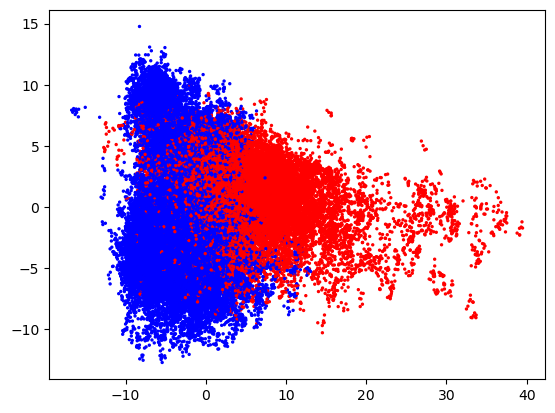

In [14]:
# Create a PCA instance with 2 components
pca = PCA(n_components=2)

# Fit and transform your data to 2D
X_2d = pca.fit_transform(X.reshape(X.shape[0], -1))

# Create a dictionary to map labels to colors
label_to_color = {0: "blue", 1: "red"}
y = y.ravel()
# Create a list of colors based on the labels
point_colors = [label_to_color[label] for label in y]

# Now you can create a 2D scatter plot with the specified colors
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=point_colors, s=2)
plt.show()

As we see, we have 60361 images. Each images has a shape of **(64,64, 3)=(image_width, image_height, number_of_channels)**

### Plot Sample Images:

The function `plot_sample_images` takes three parameters: `X` (image data), `y` (labels), and an optional parameter `n` (number of sample images to display, default is 50).

1. **Iteration Through Labels:**
   - The function iterates through both labels (0 and 1) to separate and visualize images for each class.

2. **Selection of Sample Images:**
   - For each label, it selects the first `n` images from the dataset with the corresponding label.

3. **Arrangement in Subplots:**
   - It arranges the images in a grid of subplots (with a specified number of columns and rows).

4. **Clean Presentation:**
   - Each image is displayed in a subplot, and the ticks on the axes are removed for a cleaner presentation.

5. **Label Conversion:**
   - The function converts the numeric label to a string ("Yes" for label 1, "No" for label 0).

6. **Overall Title Setting:**
   - It sets the overall title for the set of subplots based on the converted label.

7. **Final Plot Display:**
   - The final plot is displayed.

This function provides a quick and visual way to inspect a subset of images from a dataset, grouped by their labels. It can be useful for understanding the characteristics of the data and verifying the correctness of labels.


In [15]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

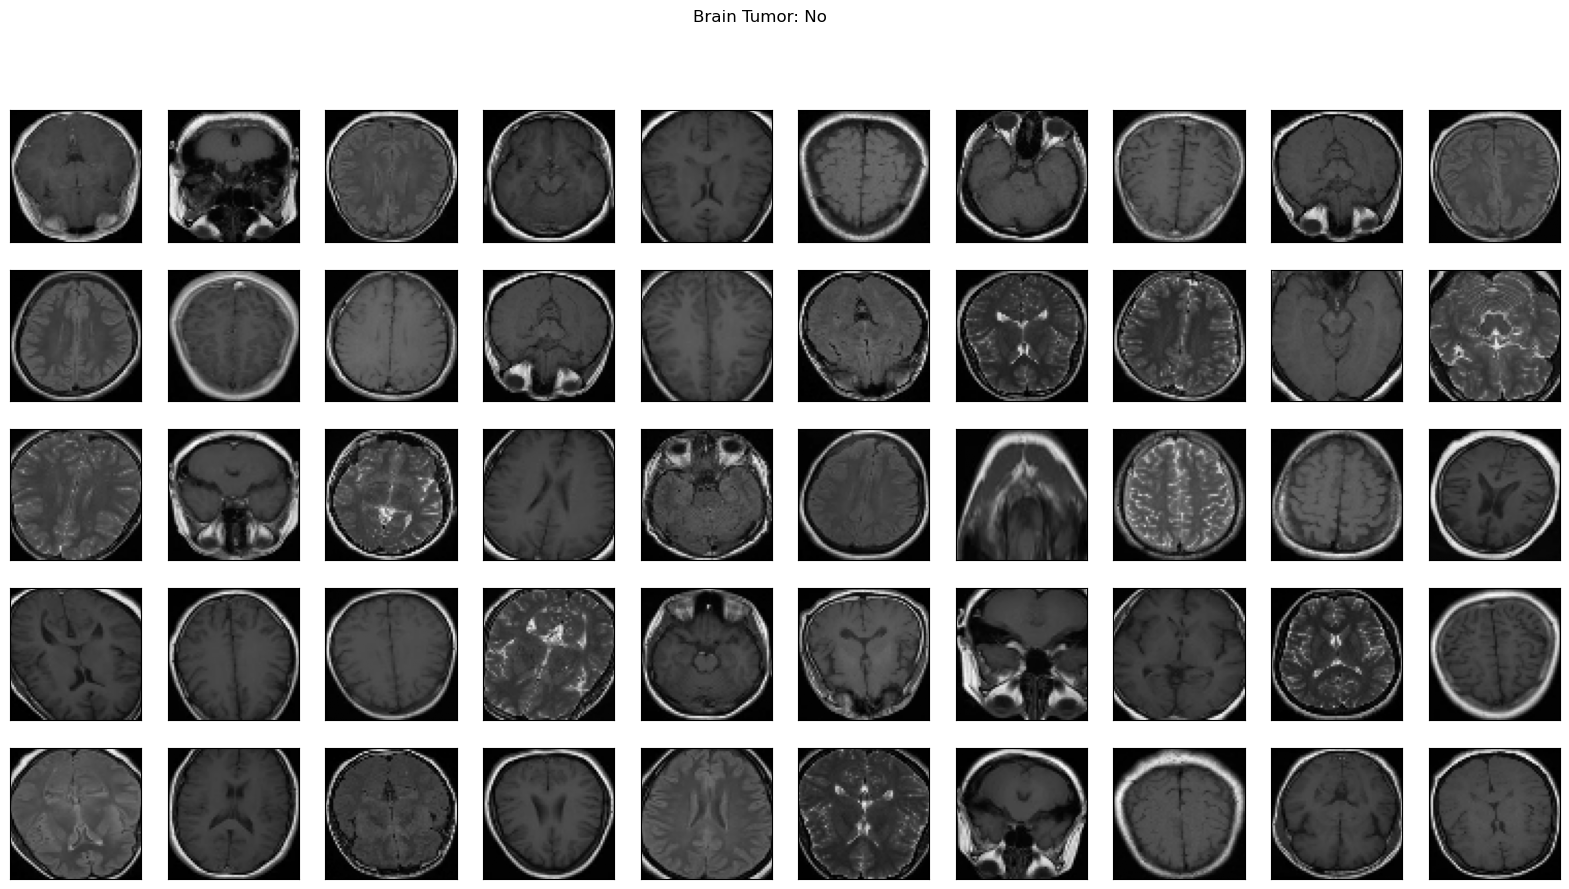

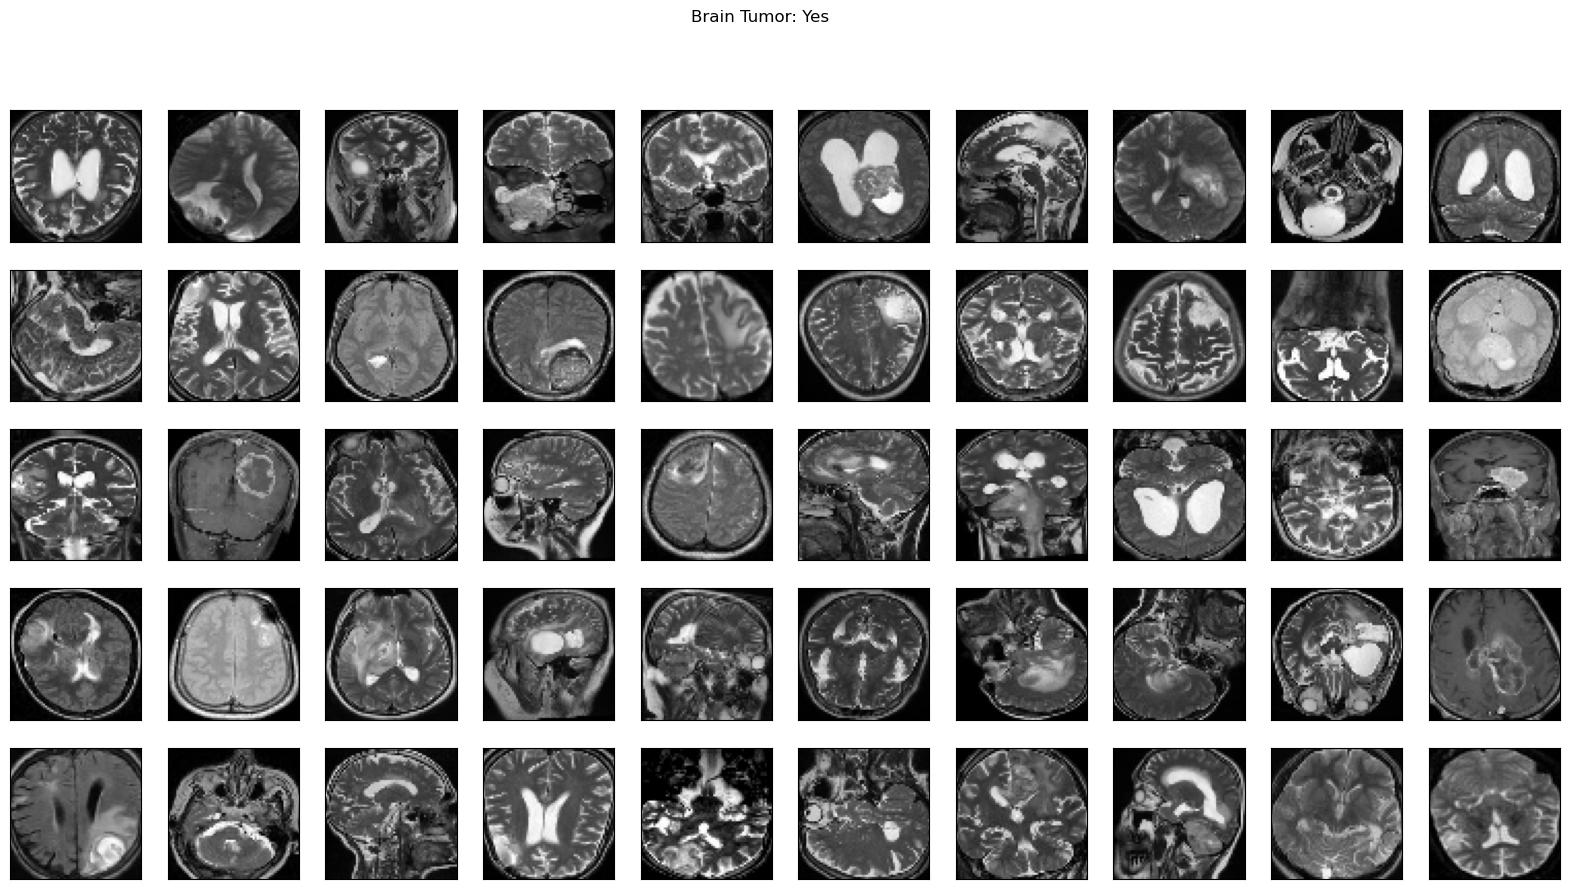

In [16]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [17]:
def split_data(X, y, test_size):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [19]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 42252
number of development examples = 9055
number of test examples = 9054
X_train shape: (42252, 64, 64, 3)
Y_train shape: (42252,)
X_val (dev) shape: (9055, 64, 64, 3)
Y_val (dev) shape: (9055,)
X_test shape: (9054, 64, 64, 3)
Y_test shape: (9054,)


Some helper functions:

# Nicely formatted time string

In [12]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

### F1_Score: ###
**Convert Probabilities to Predicted Labels:**
The line `np.where(prob > 0.5, 1, 0)` converts the vector of probabilities (`prob`) into a binary vector of predicted labels (`y_pred`). If the probability is greater than 0.5, it assigns the label 1; otherwise, it assigns the label 0. This threshold of 0.5 is a common choice in binary classification tasks.

**Compute F1 Score:**
The line `f1_score(y_true, y_pred)` calculates the F1 score using the true labels (`y_true`) and the predicted labels (`y_pred`). The F1 score is a metric that combines precision and recall, providing a balance between the two. It is particularly useful in binary classification problems.

**Return the Score:**
The function returns the computed F1 score.


In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='Convolutional-neural-network-architecture-2.png'>

### As we see in the picture, here's how my model works:

#### 1. `X_input = Input(input_shape):`
   - This line defines the input layer for the model. It creates an input tensor (X_input) with the specified shape (input_shape). This shape should match the dimensions of the input images, typically in the form (image_width, image_height, #_channels).

#### 2. `X = ZeroPadding2D((2, 2))(X_input):`
   - This line adds zero-padding to the input tensor. It pads the border of the input tensor with zeroes to address issues related to border effects in convolutional layers.

#### 3. The next three lines define a convolutional block:
   - `X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X):`
     - Convolutional layer with 32 filters of size (7, 7) and a stride of (1, 1).
   - `X = BatchNormalization(axis=3, name='bn0')(X):`
     - Batch normalization is applied along the third axis (channel axis).
   - `X = Activation('relu')(X):`
     - ReLU activation function is applied.

#### 4. `X = MaxPooling2D((4, 4), name='max_pool0')(X):`
   - Max pooling layer with a pool size of (4, 4). It reduces the spatial dimensions of the tensor.

#### 5. `X = MaxPooling2D((4, 4), name='max_pool1')(X):`
   - Another max pooling layer is applied, further reducing the spatial dimensions.

#### 6. `X = Flatten()(X):`
   - Flatten layer is applied to convert the 3D tensor into a 1D tensor, preparing it for the fully connected layer.

#### 7. `X = Dense(1, activation='sigmoid', name='fc')(X):`
   - Fully connected layer with one output unit and sigmoid activation. This is common in binary classification tasks.

#### 8. `model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel'):`
   - This line creates the Keras model instance using the input and output tensors defined earlier. The model is assigned the name 'BrainDetectionModel'.

#### 9. `return model:`
   - The function returns the created Keras model.

In summary, the function defines a simple CNN architecture for brain detection, including convolutional layers, max pooling layers, and a fully connected layer. The activation function used is ReLU for the convolutional layers and sigmoid for the output layer, indicating a binary classification task. The model is suitable for classifying whether an input image contains a brain or not.


In [15]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) 
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?,68, 68, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 68, 68, 3)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 15, 15, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 3, 3, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 288) 
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)

In [18]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 68, 68, 3)         0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 62, 62, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 62, 62, 32)        128       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 15, 15, 32)        0         
                                               

Compile the model:

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [23]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(f"models/{filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'}.model")

## Train the model

In [25]:
from keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback with a proper filepath
checkpoint = ModelCheckpoint(filepath='model_checkpoint_{epoch:02d}_{val_loss:.2f}.h5',
                             monitor='val_loss', save_best_only=True)

# Use the checkpoint callback in the model.fit() method
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, 
          validation_data=(X_val, y_val), callbacks=[checkpoint])


Epoch 1/10
1321/1321 [==============================] - 99s 75ms/step - loss: 0.1115 - accuracy: 0.9589 - val_loss: 0.1055 - val_accuracy: 0.9619
Epoch 2/10
   1/1321 [..............................] - ETA: 1:47 - loss: 0.1099 - accuracy: 0.9688

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1321/1321 [==============================] - 98s 74ms/step - loss: 0.0987 - accuracy: 0.9642 - val_loss: 0.1057 - val_accuracy: 0.9596
Epoch 3/10
1321/1321 [==============================] - 99s 75ms/step - loss: 0.0889 - accuracy: 0.9675 - val_loss: 0.1115 - val_accuracy: 0.9608
Epoch 4/10
1321/1321 [==============================] - 98s 75ms/step - loss: 0.0840 - accuracy: 0.9700 - val_loss: 0.0782 - val_accuracy: 0.9733
Epoch 5/10
1321/1321 [==============================] - 100s 76ms/step - loss: 0.0787 - accuracy: 0.9726 - val_loss: 0.0726 - val_accuracy: 0.9750
Epoch 6/10
1321/1321 [==============================] - 103s 78ms/step - loss: 0.0742 - accuracy: 0.9742 - val_loss: 0.0706 - val_accuracy: 0.9725
Epoch 7/10
1321/1321 [==============================] - 99s 75ms/step - loss: 0.0721 - accuracy: 0.9747 - val_loss: 0.0733 - val_accuracy: 0.9737
Epoch 8/10
1321/1321 [==============================] - 97s 74ms/step - loss: 0.0692 - accuracy: 0.9753 - val_loss: 0.0761 - val_accu

In [44]:
checkpoint

# Let's train for a few more epochs:
## Training Strategy with Multiple Epoch Counts

Training a neural network for a total of 20 epochs, split into separate training runs with different epoch counts (e.g., 10, 3, 3, and 5 epochs in separate runs) can be a reasonable strategy in certain scenarios. Here are some considerations:

### Fine-Tuning and Iterative Training:

Breaking the training into multiple runs can be useful for fine-tuning or iteratively improving the model. After an initial training run, you can assess the model's performance, make adjustments, and continue training.

### Resource Constraints:

Training for a large number of epochs in a single run might be computationally expensive or time-consuming. Splitting the training into smaller runs allows you to monitor progress, save checkpoints, and adjust hyperparameters more frequently.

### Model Assessment:

After each training run, you can evaluate the model's performance on validation data. This allows you to analyze the learning curves, identify potential overfitting, and make informed decisions on whether to continue training.

### Hyperparameter Tuning:

If you're experimenting with different hyperparameters, breaking the training into multiple runs provides opportunities to adjust and fine-tune these parameters based on observed performance.

### Early Stopping:

Implementing early stopping alongside checkpointing can help you stop training when the model's performance on the validation set starts to degrade, avoiding overfitting.

However, it's crucial to consider the following:

### Consistency in Evaluation:

Ensure that you are evaluating the model consistently across different training runs. For example, use the same validation set and evaluation metrics.

### Checkpoint Management:

Keep track of the best-performing model across all training runs. You may choose to select the model with the lowest validation loss among all runs.

### Learning Curves:

Analyze the learning curves (training and validation loss/accuracy) to understand how the model is learning over time. This can provide insights into the effectiveness of the training strategy.

### Training Set Size:

If your dataset is large, training for fewer epochs in each run might be more reasonable. For smaller datasets, be cautious of potential overfitting, especially if you observe a significant performance increase on the training set but not on the validation set.

In summary, the approach of training for 20 epochs in separate runs can be useful, especially when dealing with resource constraints, iterative model improvement, or hyperparameter tuning. It allows for flexibility in model development and assessment.


In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
1321/1321 [==============================] - 100s 76ms/step - loss: 0.0606 - accuracy: 0.9796 - val_loss: 0.0653 - val_accuracy: 0.9752
Epoch 2/3
1321/1321 [==============================] - 100s 76ms/step - loss: 0.0603 - accuracy: 0.9793 - val_loss: 0.0643 - val_accuracy: 0.9777
Epoch 3/3
1321/1321 [==============================] - 112s 85ms/step - loss: 0.0562 - accuracy: 0.9805 - val_loss: 0.0644 - val_accuracy: 0.9765
Elapsed time: 0:5:24.2


In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
1321/1321 [==============================] - 102s 77ms/step - loss: 0.0560 - accuracy: 0.9806 - val_loss: 0.0599 - val_accuracy: 0.9789
Epoch 2/3
1321/1321 [==============================] - 97s 74ms/step - loss: 0.0544 - accuracy: 0.9815 - val_loss: 0.0947 - val_accuracy: 0.9661
Epoch 3/3
1321/1321 [==============================] - 100s 76ms/step - loss: 0.0535 - accuracy: 0.9813 - val_loss: 0.0609 - val_accuracy: 0.9797
Elapsed time: 0:5:15.3


In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
1321/1321 [==============================] - 99s 75ms/step - loss: 0.0505 - accuracy: 0.9834 - val_loss: 0.0571 - val_accuracy: 0.9786
Epoch 2/3
1321/1321 [==============================] - 100s 75ms/step - loss: 0.0504 - accuracy: 0.9823 - val_loss: 0.0598 - val_accuracy: 0.9802
Epoch 3/3
1321/1321 [==============================] - 97s 73ms/step - loss: 0.0502 - accuracy: 0.9827 - val_loss: 0.0876 - val_accuracy: 0.9701
Elapsed time: 0:5:2.6


In [31]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
1321/1321 [==============================] - 100s 76ms/step - loss: 0.0479 - accuracy: 0.9834 - val_loss: 0.0660 - val_accuracy: 0.9758
Epoch 2/5
1321/1321 [==============================] - 97s 73ms/step - loss: 0.0466 - accuracy: 0.9843 - val_loss: 0.0564 - val_accuracy: 0.9789
Epoch 3/5
1321/1321 [==============================] - 97s 73ms/step - loss: 0.0465 - accuracy: 0.9835 - val_loss: 0.0557 - val_accuracy: 0.9805
Epoch 4/5
1321/1321 [==============================] - 97s 74ms/step - loss: 0.0429 - accuracy: 0.9855 - val_loss: 0.0613 - val_accuracy: 0.9779
Epoch 5/5
1321/1321 [==============================] - 98s 74ms/step - loss: 0.0458 - accuracy: 0.9837 - val_loss: 0.0728 - val_accuracy: 0.9738
Elapsed time: 0:8:19.5


In [32]:
history = model.history.history

In [33]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [34]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

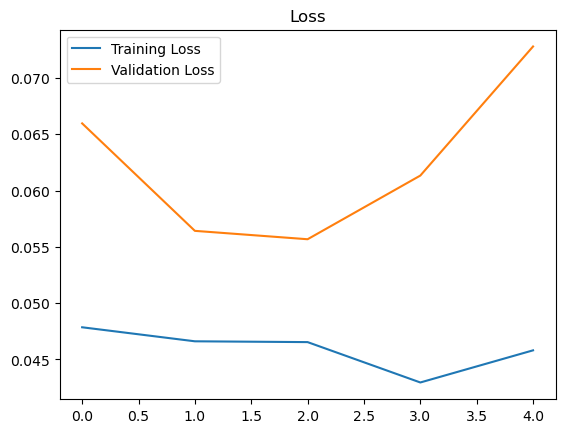

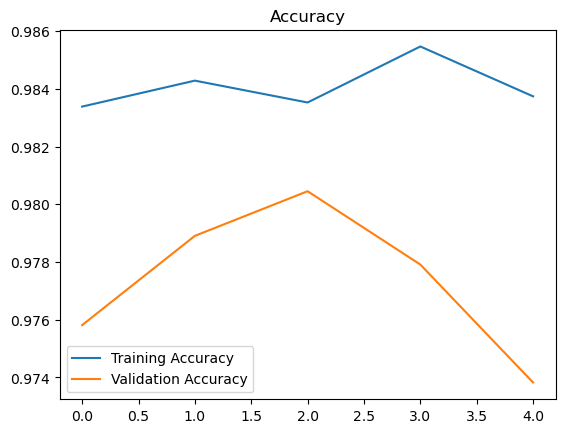

In [35]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [45]:
best_model = load_model(filepath='model_checkpoint_01_0.06.h5')

In [46]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [47]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

283/283 [==============================] - 6s 22ms/step - loss: 0.0575 - accuracy: 0.9801


In [57]:
loss, acc = best_model.evaluate(x=X_train, y=y_train)

1321/1321 [==============================] - 25s 19ms/step - loss: 0.0410 - accuracy: 0.9874


In [58]:
loss, acc = best_model.evaluate(x=X_val, y=y_val)

283/283 [==============================] - 6s 21ms/step - loss: 0.0571 - accuracy: 0.9786


### Accuracy of the best model on the testing data:

In [48]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.05750028043985367
Test Accuracy = 0.9801192879676819


### F1 score for the best model on the testing data:

In [49]:
y_test_prob = best_model.predict(X_test)

283/283 [==============================] - 6s 20ms/step


In [51]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9735605170387779


Let's also find the f1 score on the validation data:

In [52]:
y_val_prob = best_model.predict(X_val)

283/283 [==============================] - 6s 20ms/step


In [53]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9715041128084606


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [59]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [60]:
# the whole data
data_percentage(y)

Number of examples: 60361
Percentage of positive examples: 37.08851742018853%, number of pos examples: 22387
Percentage of negative examples: 62.91148257981147%, number of neg examples: 37974


In [61]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 42252
Percentage of positive examples: 36.83139259680015%, number of pos examples: 15562
Percentage of negative examples: 63.16860740319985%, number of neg examples: 26690
Validation Data:
Number of examples: 9055
Percentage of positive examples: 37.658752070679185%, number of pos examples: 3410
Percentage of negative examples: 62.341247929320815%, number of neg examples: 5645
Testing Data:
Number of examples: 9054
Percentage of positive examples: 37.718135630660484%, number of pos examples: 3415
Percentage of negative examples: 62.281864369339516%, number of neg examples: 5639


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**98%** accuracy on the **test set**.<br>
**97.3%** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 97.86%            | 98%      |
| F1 score  | 97.1%          | 97.3%     |

#   Test our model with online CT barin photo 

In [2]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np
import cv2

class BrainTumorClassifierApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Brain Tumor Classifier")

        self.model = load_model('model_checkpoint_10_0.800.h5')

        # Create GUI components
        self.label = tk.Label(root, text="Select an image:")
        self.label.pack()

        self.image_path = ""
        self.image_label = tk.Label(root)
        self.image_label.pack()

        self.browse_button = tk.Button(root, text="Browse", command=self.browse_image, height=2, width=20)
        self.browse_button.pack()

        self.predict_button = tk.Button(root, text="Predict", command=self.predict, height=2, width=20)
        self.predict_button.pack()

        self.result_label = tk.Label(root, text="")
        self.result_label.pack()

    def browse_image(self):
        self.image_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.gif;*.bmp")])
        self.show_image()

    def show_image(self):
        if self.image_path:
            img = Image.open(self.image_path)
            img.thumbnail((500, 500))  # Adjust the size as needed
            img = ImageTk.PhotoImage(img)
            self.image_label.configure(image=img)
            self.image_label.image = img

    def predict(self):
        if self.image_path:
            img = image.load_img(self.image_path, target_size=(64, 64))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = self.model.predict(img_array)
            threshold = predictions  # You may need to adjust this based on your model's output

            if predictions[0] == 0:
                result = "Prediction: the person is Normal"
                self.result_label.configure(text=result, fg="green", font=("Arial", 12, "bold"))
            else:
                result = "Prediction: the person has Brain Tumor"
                self.result_label.configure(text=result, fg="red", font=("Arial", 12, "bold"))

if __name__ == "__main__":
    root = tk.Tk()
    app = BrainTumorClassifierApp(root)
    root.mainloop()

1/1 [==============================] - 0s 14ms/step


# END.